In [5]:
from __future__ import print_function
import pandas as pd
import argparse
import torch
import json
from torch import nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from __future__ import unicode_literals
from hazm import *

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
device

device(type='cuda')

In [3]:
df_train = pd.read_csv("./News/train.csv", sep='\t', error_bad_lines= False , encoding= 'utf-8')
df_test = pd.read_csv("./News/test.csv", sep='\t', error_bad_lines= False , encoding= 'utf-8')

In [8]:
class DataPreprocessor:
    
    def __init__(self, train_data="./News/train.csv", test_data="./News/test.csv", mode="train"):
        self.read_data(train_data, test_data)
        self.plot_distribution(mode=mode)
        self.clean_text(mode=mode)
        self.count_words()
        self.map_word_index()
        setattr(self,f"{mode}", self.tokenizer())
        
        
    def first_item(self):
        return self.train_data[0]
    
    def read_data(self ,train_data, test_data):
        self.train_data = pd.read_csv(train_data, sep="\t", error_bad_lines=False, encoding="utf-8")
        self.train_data = self.train_data.dropna(subset=['category'])
        self.train_data = self.train_data.loc[self.train_data['category']!='category']
        self.test_data = pd.read_csv(test_data, sep="\t", error_bad_lines=False, encoding="utf-8")
        self.test_data = self.test_data.dropna(subset=['category'])
        self.test_data = self.test_data.loc[self.test_data['category']!='category']
    
    def plot_distribution(self, mode="train"):
        if mode=="train":
            self.train_data['category'].value_counts(sort=False).plot(kind='bar')
        else:
            self.test_data['category'].value_counts(sort=False).plot(kind='bar')
        
    
    def clean_text(self, mode="train"):
        ws = []
        source = self.train_data.text
        if mode=="test":
            source = self.test_data.text
        for a in source.astype(str):
            w = [tk for tk in word_tokenize(a) if tk.isalpha()] + ['<eos>']
            ws.append(w)
        self.cleaned_data = ws
        www = []
        for w in self.cleaned_data:
            ww = []
            for item in w:
                if "." in item:
                    if item.split(".")[0]!='':
                        ww.extend([item.split(".")[0]])
                elif not item.encode().isalpha():
                    ww.append(item)
            www.append(ww)
            
        self.tokenized_data = www
        print(www[:1])
            
    
    def count_words(self):
        www = self.tokenized_data
        di = dict()
        for ww in www:
            for i in ww:
                if i not in di:
                    di[i] = 1
                else:
                    di[i]+=1
        srt = sorted(di.items(), key=lambda item: item[1],reverse=True)
        asrt = srt
        self.tokens = asrt
        with open("‫‪frequencies‬‬.txt","w") as file:
            file.write(str(srt[:200]))
        dictionary = dict(asrt)
        print(f"tokens={sum(di.values())}, and unique tokens are={len(srt)}")
        self.frequencies_dict = dictionary
        self.n_tokens = sum(di.values())
        self.n_unique_tokens = len(srt)

    def map_word_index(self):
        vocabs = self.frequencies_dict.keys()
        self.word_to_index = {}
        self.index_to_word = {}
        for index , vocab in enumerate(vocabs):
            self.index_to_word[index] = vocab
            self.word_to_index[vocab] = index
        print("Saving dictionary...")
        with open("‫‪indeces‬‬.json","w") as file:
            json.dump(self.word_to_index, file, ensure_ascii=False)
        print("Saving dictionary finished")
        
    
    def tokenizer(self):
        www = []
        for w in self.tokenized_data:
            ww = []
            for item in w:
                ww.append(self.word_to_index[item])
            www.append(torch.tensor(ww).type(torch.int64))
            
        self.tokenized_tokens = www
        print(www[0])
        return torch.cat(www)
    

[['به', 'گزارش', 'خبرنگار', 'حوزه', 'میراث', 'و', 'فرهنگی', 'باشگاه', 'خبرنگاران', 'جوان', 'محمد', 'حسن', 'خان', 'اعتماد', 'السلطنه', 'به', 'نقل', 'از', 'برخی', 'منابع', 'اسفراین', 'چمن', 'کالپوش', 'چمن', 'کالپوش', 'بر', 'اساس', 'آنچه', 'در', 'اعتقادات', 'اهالی', 'منطقه', 'مشهود', 'است', 'آخرین', 'منزلگاه', 'داریوش', 'سوم', 'است', 'بنابراین', 'باید', 'دشت', 'اسفراین', 'را', 'جولانگاه', 'مقدونیان', 'دانست', 'این', 'دشت', 'از', 'دستبرد', 'و', 'سم', 'ستوران', 'یونانی', 'در', 'امان', 'بنا', 'بر', 'این', 'گزارش', 'شهر', 'اسفراین', 'امروزی', 'در', 'شمال', 'غربی', 'استان', 'خراسان', 'شمالی', 'قرار', 'این', 'شهر', 'دربرگیرنده', 'بیش', 'از', 'بقعه', 'از', 'بزرگان', 'و', 'امامزادگان', 'است', 'شایان', 'ذکر', 'است', 'شهر', 'فعلی', 'اسفراین', 'از', 'محله', 'تشکیل', 'شده', 'و', 'زیستگاه', 'حیواناتی', 'چون', 'آهو', 'گرگ', 'گورکن', 'خرگوش', 'روباه', 'گراز', 'پلنگ', 'کفتار', 'و', 'بز', 'کوهی', 'است', 'منطقه', 'ساری', 'گل', 'در', 'شمال', 'شرقی', 'اسفراین', 'قرار', 'گفتنی', 'است', 'ابوعبدلله', 'حمد', 'بن

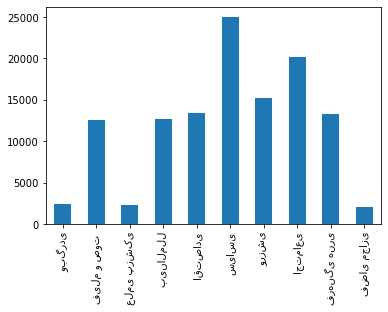

In [9]:
data_train = DataPreprocessor()
data_test = DataPreprocessor(mode="test")

In [30]:
pd.Categorical(data_train.train_data.category)

[فرهنگی هنری, فرهنگی هنری, فرهنگی هنری, فرهنگی هنری, فرهنگی هنری, ..., ورزشی, ورزشی, ورزشی, ورزشی, ورزشی]
Length: 117153
Categories (10, object): [اجتماعی, اقتصادی, بین‌الملل, سیاسی, ..., فضای مجازی, فیلم و صوت, وب‌گردی, ورزشی]

In [6]:
class CustomDataset(Dataset):
    
    def __init__(self, text, label):
        self.text = text
        self.label = label
        
    def __len__(self):
        assert len(self.text)==len(self.label)
        return len(self.text)
    
    def __getitem__(self, idx):
        return {"text": self.text[idx], "label": self.label[idx]}

In [23]:
train_dataset = CustomDataset(data_train.tokenized_tokens, pd.Categorical(data_train.train_data.category).codes)

In [85]:
test_dataset = CustomDataset(data_test.tokenized_tokens, pd.Categorical(data_test.test_data.category).codes)

In [78]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
#     for (_text, _label) in batch:
    for _item in batch:
         _label, _text = _item["label"], _item["text"]
         label_list.append(_label)
         processed_text = _text
         text_list.append(processed_text)
#          print("&&&&&&&", processed_text, _text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list, text_list, offsets


In [79]:
dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [80]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [81]:
vocab_size = len(data_train.word_to_index)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, 10)

In [82]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()
    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [86]:
from torch.utils.data.dataset import random_split
# Hyperparameters
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataset = list(train_dataset)
test_dataset = list(test_dataset)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)


for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 1739 batches | accuracy    0.764
| epoch   1 |  1000/ 1739 batches | accuracy    0.758
| epoch   1 |  1500/ 1739 batches | accuracy    0.759
-----------------------------------------------------------
| end of epoch   1 | time: 25.67s | valid accuracy    0.770 
-----------------------------------------------------------
| epoch   2 |   500/ 1739 batches | accuracy    0.766
| epoch   2 |  1000/ 1739 batches | accuracy    0.765
| epoch   2 |  1500/ 1739 batches | accuracy    0.763
-----------------------------------------------------------
| end of epoch   2 | time: 26.02s | valid accuracy    0.775 
-----------------------------------------------------------
| epoch   3 |   500/ 1739 batches | accuracy    0.768
| epoch   3 |  1000/ 1739 batches | accuracy    0.768
| epoch   3 |  1500/ 1739 batches | accuracy    0.765
-----------------------------------------------------------
| end of epoch   3 | time: 26.86s | valid accuracy    0.765 
-------------------------------

In [87]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.306
